In [2]:

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from train import TrainProcedure
from losocv import LosoCv

trainProc = TrainProcedure()
loso = LosoCv()

In [2]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [3]:
# CREATE TRAINING AND VALIDATION DATASET FROM MICRO_EXPRESION COMBINED DATASET
from tensorflow.keras.preprocessing import image_dataset_from_directory

#me_train_dataset = image_dataset_from_directory(ME_path, labels='inferred', label_mode='int',
#                    validation_split=0.2, subset='training',
#                    seed=1234, image_size=(224,224), color_mode='rgb')
#me_val_dataset = image_dataset_from_directory(ME_path, labels='inferred', label_mode='int',
#                    validation_split=0.2, subset='validation',
#                    seed=1234, image_size=(224,224), color_mode='rgb')       

#print(me_train_dataset.class_names)

## Building Model EfficientNetB0

- initialized with weights from pre-trained imageNet
- remove top and freeze all base layers
- add new top

In [3]:
INPUT_SHAPE = (224,224,3)
effB0_model = EfficientNetB0(weights='imagenet', 
                include_top=False, input_shape=INPUT_SHAPE)
effB0_model.trainable = False
effB0_model.summary()


Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

In [5]:
# ADD NEW TRAINABLE LAYERS ON TOP TO BUILD THE FINAL MODEL
from tensorflow.keras.layers.experimental.preprocessing import RandomContrast, RandomFlip
from tensorflow.keras.models import Model
from tensorflow.keras import Input, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

BASE_MODEL_PATH = './trainingWeights/baseModel.h5'
inputs = Input(shape=(224,224,3))
#data_augmentation = Sequential([RandomFlip('horizontal'), RandomContrast(0.2)])
#x = preprocess_input(inputs)
x = effB0_model(inputs, training=False) #run in inference mode
x = GlobalAveragePooling2D()(x)
#x = Dropout(0.2)(x)
outputs = Dense(7,activation='softmax')(x) #7 output classes
model = Model(inputs, outputs)
model.save(BASE_MODEL_PATH)
model.summary()


c:\Users\User\Documents\UKM\Project\Models\EfficientNet\effNetVenv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 7)                 8967      
                                                                 
Total params: 4,058,538
Trainable params: 8,967
Non-trainable params: 4,049,571
_________________________________________________________________


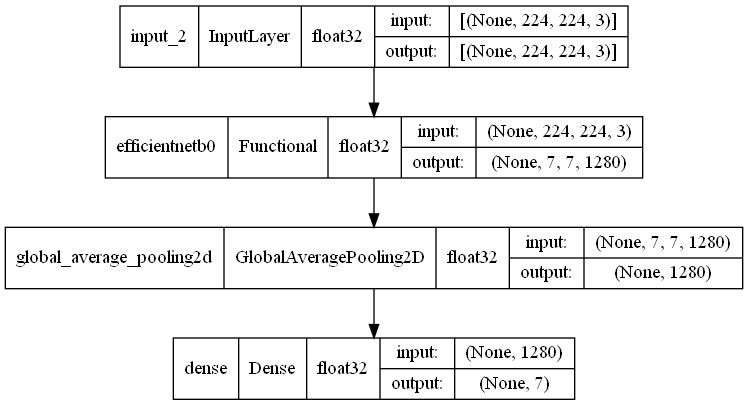

In [6]:
tf.keras.utils.plot_model(
    model,
    to_file='./savedModel/EffB0-baseModel.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
)

In [9]:
#Sub-class Model class so that we can conveniently create one each training run

class CustomTLModel(Model):
    
    def __init__(self, name):
        super().__init__(name=name)
        inp_shape = (224,224,3)
        self.effB0_model = EfficientNetB0(weights='imagenet', 
                include_top=False, input_shape=inp_shape)
        self.effB0_model.trainable = False
        self.gap = GlobalAveragePooling2D()
        self.classifier = Dense(7,activation='softmax')
        
    def call(self, inputs, training=False):
        #data_augmentation = Sequential([RandomFlip('horizontal'), RandomContrast(0.2)])
        #x = preprocess_input(inputs) --> not needed since this is included in effNet already
        x = self.effB0_model(inputs, training=training) #run in inference mode
        x = self.gap(x)
        outputs = self.classifier(x) #7 output classes
        return Model(inputs, outputs)

def createModel(name):
    inp_shape = (224,224,3)
    effB0_model = EfficientNetB0(weights='imagenet', 
                include_top=False, input_shape=inp_shape)
    effB0_model.trainable = False
    
    inputs = Input(inp_shape)
    x = effB0_model(inputs, training=False) #run in inference mode
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(7,activation='softmax')(x) #7 output classes
    return Model(inputs, outputs, name)   

# Experiments

## Base model

In [17]:
#testing 123

FOLDER_NAME = '.\\trainingWeights\\'
#subjects = loso.getSubjects()
#subject = subjects[0]
subject='smic-s5'
testSet = loso.getTestDataSet(subject)
trainDataset,valDataset = loso.getTrainValDataSet(subject)
ftHistories = []
model = load_model(BASE_MODEL_PATH)
name = '{}model-{}-headtraining-3dec-base'.format(FOLDER_NAME,subject)
history1 = trainProc.trainHead(model,trainDataset, valDataset, name)

for i in range(10):  
    name = '{}model-{}-iteration-{}-3dec-base'.format(FOLDER_NAME,subject,i)
    ftHist = trainProc.trainAll(model,trainDataset, valDataset, name)
    ftHistories.append(ftHist)

Learn the head
Epoch 1/5
9/9 [==============================] - ETA: 0s - loss: 1.8721 - accuracy: 0.1842 
Epoch 00001: val_accuracy improved from -inf to 0.38462, saving model to .\trainingWeights\model-smic-s5-headtraining-3dec-base.h5


c:\Users\User\Documents\UKM\Project\Models\EfficientNet\effNetVenv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


9/9 [==============================] - 99s 10s/step - loss: 1.8721 - accuracy: 0.1842 - val_loss: 1.5802 - val_accuracy: 0.3846
Epoch 2/5
9/9 [==============================] - ETA: 0s - loss: 1.6462 - accuracy: 0.3496
Epoch 00002: val_accuracy improved from 0.38462 to 0.50769, saving model to .\trainingWeights\model-smic-s5-headtraining-3dec-base.h5
9/9 [==============================] - 84s 9s/step - loss: 1.6462 - accuracy: 0.3496 - val_loss: 1.4782 - val_accuracy: 0.5077
Epoch 3/5
9/9 [==============================] - ETA: 0s - loss: 1.5602 - accuracy: 0.4023
Epoch 00003: val_accuracy improved from 0.50769 to 0.53846, saving model to .\trainingWeights\model-smic-s5-headtraining-3dec-base.h5
9/9 [==============================] - 85s 9s/step - loss: 1.5602 - accuracy: 0.4023 - val_loss: 1.4187 - val_accuracy: 0.5385
Epoch 4/5
9/9 [==============================] - ETA: 0s - loss: 1.4956 - accuracy: 0.4361
Epoch 00004: val_accuracy did not improve from 0.53846
9/9 [=================

In [19]:
import os

os.mkdir('./history/dec3test')
saveModelHistory('dec3test','smic-s5-base', ftHistories)

## Add dropout layer

In [20]:
# ADD NEW TRAINABLE LAYERS ON TOP TO BUILD THE FINAL MODEL
from tensorflow.keras.layers.experimental.preprocessing import RandomContrast, RandomFlip
from tensorflow.keras.models import Model
from tensorflow.keras import Input, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

BASE_MODEL_DROPOUT_PATH = './trainingWeights/baseModel-dropout.h5'
inputs = Input(shape=(224,224,3))
#data_augmentation = Sequential([RandomFlip('horizontal'), RandomContrast(0.2)])
#x = preprocess_input(inputs)
x = effB0_model(inputs, training=False) #run in inference mode
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(7,activation='softmax')(x) #7 output classes
model2 = Model(inputs, outputs)
model2.save(BASE_MODEL_DROPOUT_PATH)
model2.summary()


c:\Users\User\Documents\UKM\Project\Models\EfficientNet\effNetVenv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 7)                 8967      
                                                                 
Total params: 4,058,538
Trainable params: 8,967
Non-trainable params: 4,049,571
_____________________________________________

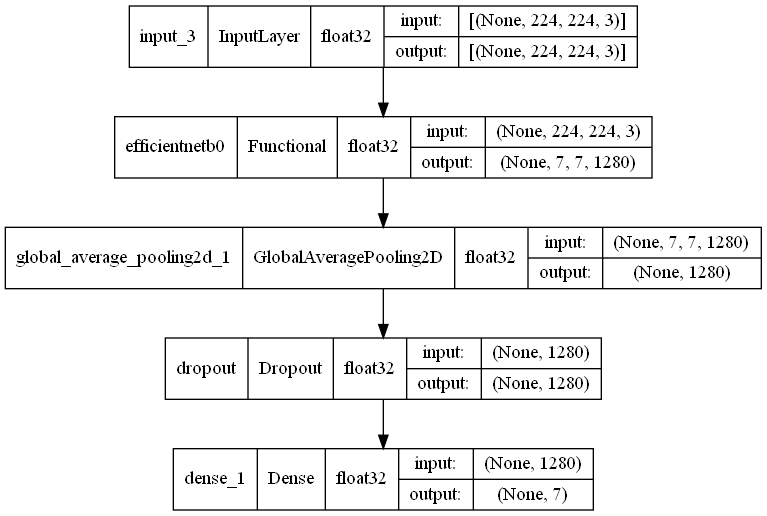

In [22]:
tf.keras.utils.plot_model(
    model2,
    to_file='./savedModel/EffB0-baseModel-dropout.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
)

In [23]:
ftHistories2 = []
model2 = load_model(BASE_MODEL_DROPOUT_PATH)
name = '{}model-{}-headtraining-3dec-dropout'.format(FOLDER_NAME,subject)
history1 = trainHead(model2,trainDataset, valDataset, name)

for i in range(10):  
    name = '{}model-{}-iteration-{}-3dec-dropout'.format(FOLDER_NAME,subject,i)
    ftHist = trainAll(model2,trainDataset, valDataset, name)
    ftHistories2.append(ftHist)

Learn the head
Epoch 1/5
9/9 [==============================] - ETA: 0s - loss: 1.8557 - accuracy: 0.2068 
Epoch 00001: val_accuracy improved from -inf to 0.35385, saving model to .\trainingWeights\model-smic-s5-headtraining-3dec-dropout.h5


c:\Users\User\Documents\UKM\Project\Models\EfficientNet\effNetVenv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


9/9 [==============================] - 100s 11s/step - loss: 1.8557 - accuracy: 0.2068 - val_loss: 1.6131 - val_accuracy: 0.3538
Epoch 2/5
9/9 [==============================] - ETA: 0s - loss: 1.6720 - accuracy: 0.3308 
Epoch 00002: val_accuracy improved from 0.35385 to 0.44615, saving model to .\trainingWeights\model-smic-s5-headtraining-3dec-dropout.h5
9/9 [==============================] - 91s 10s/step - loss: 1.6720 - accuracy: 0.3308 - val_loss: 1.5215 - val_accuracy: 0.4462
Epoch 3/5
9/9 [==============================] - ETA: 0s - loss: 1.6086 - accuracy: 0.3571
Epoch 00003: val_accuracy improved from 0.44615 to 0.47692, saving model to .\trainingWeights\model-smic-s5-headtraining-3dec-dropout.h5
9/9 [==============================] - 88s 10s/step - loss: 1.6086 - accuracy: 0.3571 - val_loss: 1.4643 - val_accuracy: 0.4769
Epoch 4/5
9/9 [==============================] - ETA: 0s - loss: 1.5400 - accuracy: 0.4060
Epoch 00004: val_accuracy did not improve from 0.47692
9/9 [=======

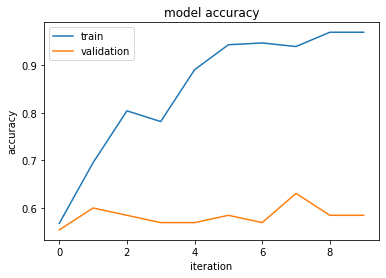

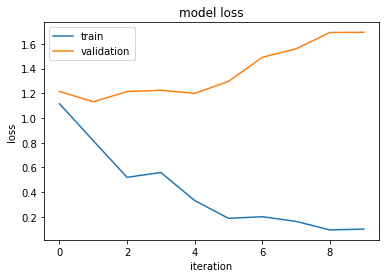

In [25]:
saveModelHistory('dec3test','smic-s5-dropout', ftHistories2)
plotAccLoss(ftHistories2)

## Add L1,L2 regularizer

c:\Users\User\Documents\UKM\Project\Models\EfficientNet\effNetVenv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 7)                 8967      
                                                                 
Total params: 4,058,538
Trainable params: 8,967
Non-trainable params: 4,049,571
_____________________________________________

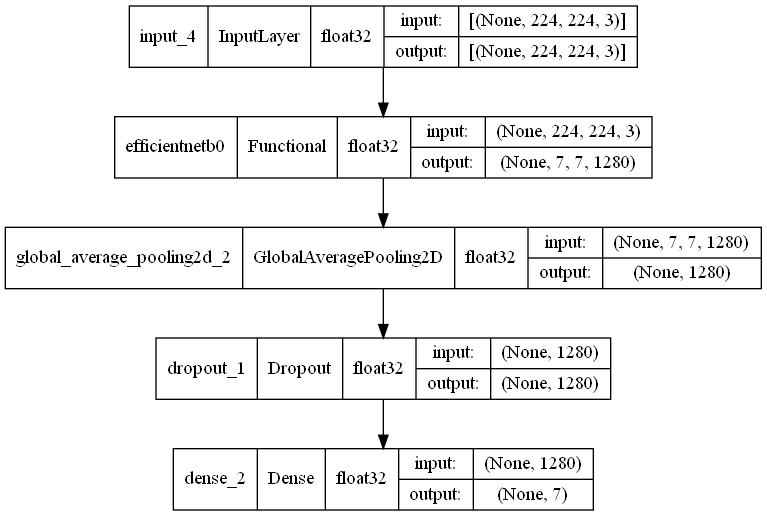

In [26]:
BASE_MODEL_REG_PATH = './trainingWeights/baseModel-dropoutReg.h5'
inputs = Input(shape=(224,224,3))
#data_augmentation = Sequential([RandomFlip('horizontal'), RandomContrast(0.2)])
#x = preprocess_input(inputs)
x = effB0_model(inputs, training=False) #run in inference mode
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(7,activation='softmax', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))(x) #7 output classes
model3 = Model(inputs, outputs)
model3.save(BASE_MODEL_REG_PATH)
model3.summary()
tf.keras.utils.plot_model(
    model3,
    to_file='./savedModel/EffB0-baseModel-dropoutReg.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
)

In [27]:
ftHistories3 = []
model3 = load_model(BASE_MODEL_REG_PATH)
name = '{}model-{}-headtraining-3dec-dropout'.format(FOLDER_NAME,subject)
history1 = trainHead(model3,trainDataset, valDataset, name)

for i in range(10):  
    name = '{}model-{}-iteration-{}-3dec-reg'.format(FOLDER_NAME,subject,i)
    ftHist = trainAll(model3,trainDataset, valDataset, name)
    ftHistories3.append(ftHist)

Learn the head
Epoch 1/5
9/9 [==============================] - ETA: 0s - loss: 4.9026 - accuracy: 0.2218 
Epoch 00001: val_accuracy improved from -inf to 0.33846, saving model to .\trainingWeights\model-smic-s5-headtraining-3dec-dropout.h5


c:\Users\User\Documents\UKM\Project\Models\EfficientNet\effNetVenv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


9/9 [==============================] - 119s 12s/step - loss: 4.9026 - accuracy: 0.2218 - val_loss: 4.4560 - val_accuracy: 0.3385
Epoch 2/5
9/9 [==============================] - ETA: 0s - loss: 4.2908 - accuracy: 0.3120 
Epoch 00002: val_accuracy improved from 0.33846 to 0.35385, saving model to .\trainingWeights\model-smic-s5-headtraining-3dec-dropout.h5
9/9 [==============================] - 104s 12s/step - loss: 4.2908 - accuracy: 0.3120 - val_loss: 3.9147 - val_accuracy: 0.3538
Epoch 3/5
9/9 [==============================] - ETA: 0s - loss: 3.7957 - accuracy: 0.3534 
Epoch 00003: val_accuracy improved from 0.35385 to 0.46154, saving model to .\trainingWeights\model-smic-s5-headtraining-3dec-dropout.h5
9/9 [==============================] - 98s 11s/step - loss: 3.7957 - accuracy: 0.3534 - val_loss: 3.4729 - val_accuracy: 0.4615
Epoch 4/5
9/9 [==============================] - ETA: 0s - loss: 3.3850 - accuracy: 0.3797 
Epoch 00004: val_accuracy did not improve from 0.46154
9/9 [====

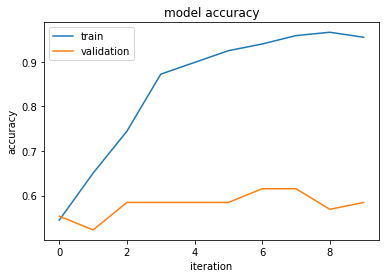

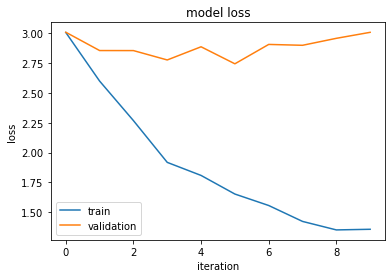

In [28]:
trainProc.saveModelHistory('dec3test','smic-s5-reg', ftHistories3)
trainProc.plotBestAccLoss(ftHistories3)

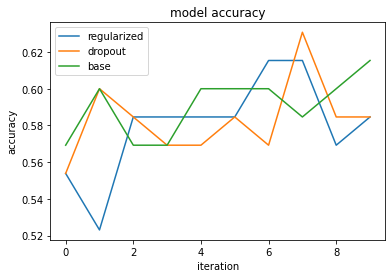

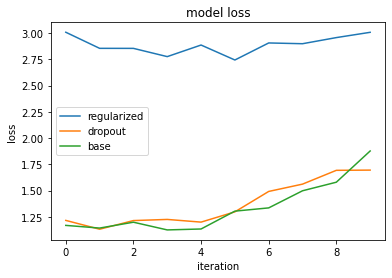

In [29]:
#Compare base model, dropout model and dropout + reg model
import matplotlib.pyplot as plt

best_v_losses_b = [min(x.history['val_loss']) for x in ftHistories]
best_v_accuracies_b = [max(x.history['val_accuracy']) for x in ftHistories]
best_v_losses_d = [min(x.history['val_loss']) for x in ftHistories2]
best_v_accuracies_d = [max(x.history['val_accuracy']) for x in ftHistories2]
best_v_losses_r = [min(x.history['val_loss']) for x in ftHistories3]
best_v_accuracies_r = [max(x.history['val_accuracy']) for x in ftHistories3]

plt.plot(best_v_accuracies_r, label = 'regularized')
plt.plot(best_v_accuracies_d, label = 'dropout')
plt.plot(best_v_accuracies_b, label = 'base')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('iteration')
plt.legend()
plt.show()

plt.plot(best_v_losses_r, label = 'regularized')
plt.plot(best_v_losses_d, label = 'dropout')
plt.plot(best_v_losses_b, label = 'base')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend()
plt.show()


## Batch size

In [32]:
ftHistoriesBatch1 = []
model4 = load_model(BASE_MODEL_REG_PATH)
name = '{}model-{}-headtraining-3dec-bsize16'.format(FOLDER_NAME,subject)
history1 = trainProc.trainHead(model4,trainDataset, valDataset, name)

for i in range(10):  
    name = '{}model-{}-iteration-{}-3dec-bsize16'.format(FOLDER_NAME,subject,i)
    ftHist = trainProc.trainAll(model4,trainDataset, valDataset, name, batch_size=16)
    ftHistoriesBatch1.append(ftHist)

Learn the head
Epoch 1/5
9/9 [==============================] - ETA: 0s - loss: 4.9153 - accuracy: 0.2180 
Epoch 00001: val_accuracy improved from -inf to 0.29231, saving model to .\trainingWeights\model-smic-s5-headtraining-3dec-bsize16.h5


c:\Users\User\Documents\UKM\Project\Models\EfficientNet\effNetVenv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


9/9 [==============================] - 100s 11s/step - loss: 4.9153 - accuracy: 0.2180 - val_loss: 4.4552 - val_accuracy: 0.2923
Epoch 2/5
9/9 [==============================] - ETA: 0s - loss: 4.2883 - accuracy: 0.2707 
Epoch 00002: val_accuracy improved from 0.29231 to 0.33846, saving model to .\trainingWeights\model-smic-s5-headtraining-3dec-bsize16.h5
9/9 [==============================] - 94s 11s/step - loss: 4.2883 - accuracy: 0.2707 - val_loss: 3.9138 - val_accuracy: 0.3385
Epoch 3/5
9/9 [==============================] - ETA: 0s - loss: 3.8104 - accuracy: 0.3271 
Epoch 00003: val_accuracy improved from 0.33846 to 0.43077, saving model to .\trainingWeights\model-smic-s5-headtraining-3dec-bsize16.h5
9/9 [==============================] - 108s 12s/step - loss: 3.8104 - accuracy: 0.3271 - val_loss: 3.4744 - val_accuracy: 0.4308
Epoch 4/5
9/9 [==============================] - ETA: 0s - loss: 3.3593 - accuracy: 0.3797 
Epoch 00004: val_accuracy improved from 0.43077 to 0.44615, savi

In [ ]:
saveModelHistory('dec3test','smic-s5-head-bestvalLoss-epoch15', history1)


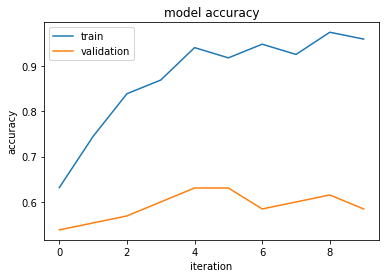

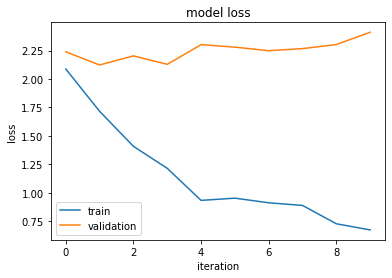

In [33]:
saveModelHistory('dec3test','smic-s5-bsize16', ftHistoriesBatch1)
plotAccLoss(ftHistoriesBatch1)

## Training for more epochs vs more iterations

- to take advantage of the decaying learning rate

Learn the head
Epoch 1/15
9/9 [==============================] - ETA: 0s - loss: 4.9117 - accuracy: 0.2481 
Epoch 00001: val_loss improved from inf to 4.45708, saving model to .\trainingWeights\model-smic-s5-headtraining-3dec-epoch50.h5
9/9 [==============================] - 104s 11s/step - loss: 4.9117 - accuracy: 0.2481 - val_loss: 4.4571 - val_accuracy: 0.2769
Epoch 2/15
9/9 [==============================] - ETA: 0s - loss: 4.2875 - accuracy: 0.2782 
Epoch 00002: val_loss improved from 4.45708 to 3.92010, saving model to .\trainingWeights\model-smic-s5-headtraining-3dec-epoch50.h5
9/9 [==============================] - 98s 11s/step - loss: 4.2875 - accuracy: 0.2782 - val_loss: 3.9201 - val_accuracy: 0.3538
Epoch 3/15
9/9 [==============================] - ETA: 0s - loss: 3.7729 - accuracy: 0.3722 
Epoch 00003: val_loss improved from 3.92010 to 3.48105, saving model to .\trainingWeights\model-smic-s5-headtraining-3dec-epoch50.h5
9/9 [==============================] - 100s 11s/step -

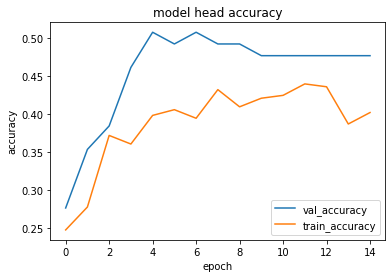

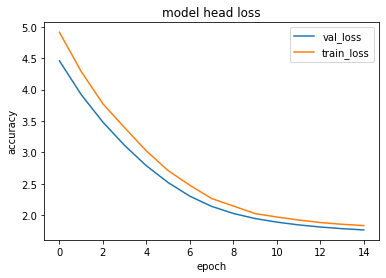

In [47]:
#train head for more epochs
import TrainProcedure
model5 = load_model(BASE_MODEL_REG_PATH)
name = '{}model-{}-headtraining-3dec-epoch50'.format(FOLDER_NAME,subject)
history1 = trainHead(model5,trainDataset, valDataset, name, batch_size=BATCH_SIZE, epoch=15)

plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history1.history['accuracy'], label = 'train_accuracy')
plt.title('model head accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(history1.history['val_loss'], label = 'val_loss')
plt.plot(history1.history['loss'], label = 'train_loss')
plt.title('model head loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [49]:
filename = '.\history\dec3test\smic-s5-head-bestvalLoss-epoch15'
with open(filename, 'w') as f:
    json.dump(history1.history, f)
model5.save('./savedModel/bestHead-epoch15.h5')

c:\Users\User\Documents\UKM\Project\Models\EfficientNet\effNetVenv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Use val_loss for EarlyStopping and increase epoch for finetuning

In [51]:
#ftHistoriesE50 = []
#model5 = load_model(BASE_MODEL_REG_PATH)
#name = '{}model-{}-headtraining-3dec-epoch50'.format(FOLDER_NAME,subject)
#history1 = trainHead(model5,trainDataset, valDataset, name)

name = '{}model-{}-3dec-epoch50'.format(FOLDER_NAME,subject)
ftHistoriesE50 = trainAll(model5,trainDataset, valDataset, name, batch_size=16, epoch=50)

Fine-tuning whole network
Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 1.8887 - accuracy: 0.3647
Epoch 00001: val_loss improved from inf to 1.64929, saving model to .\trainingWeights\model-smic-s5-3dec-epoch50_finetune.h5
17/17 [==============================] - 111s 6s/step - loss: 1.8887 - accuracy: 0.3647 - val_loss: 1.6493 - val_accuracy: 0.4923
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 1.7118 - accuracy: 0.4737
Epoch 00002: val_loss improved from 1.64929 to 1.58611, saving model to .\trainingWeights\model-smic-s5-3dec-epoch50_finetune.h5
17/17 [==============================] - 102s 6s/step - loss: 1.7118 - accuracy: 0.4737 - val_loss: 1.5861 - val_accuracy: 0.5077
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 1.5984 - accuracy: 0.5113
Epoch 00003: val_loss improved from 1.58611 to 1.51115, saving model to .\trainingWeights\model-smic-s5-3dec-epoch50_finetune.h5
17/17 [==============================] - 109s 6s/

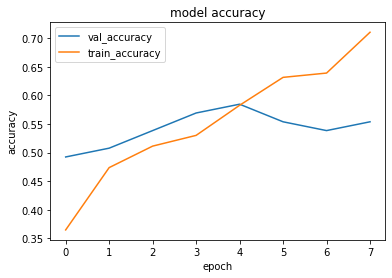

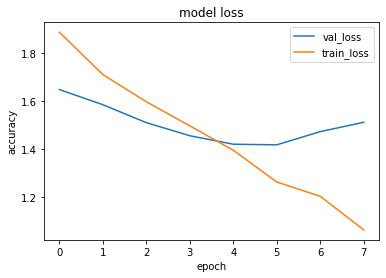

In [53]:
plt.plot(ftHistoriesE50.history['val_accuracy'], label = 'val_accuracy')
plt.plot(ftHistoriesE50.history['accuracy'], label = 'train_accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(ftHistoriesE50.history['val_loss'], label = 'val_loss')
plt.plot(ftHistoriesE50.history['loss'], label = 'train_loss')
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [54]:

ftHistoriesE15 = []
model5 = load_model('./savedModel/bestHead-epoch15.h5')

for i in range(10):  
    name = '{}model-{}-iteration-{}-3dec-bsize16-epoch15'.format(FOLDER_NAME,subject,i)
    ftHist = trainAll(model5,trainDataset, valDataset, name, batch_size=16, epoch=15)
    ftHistoriesE15.append(ftHist)

Fine-tuning whole network
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.8029 - accuracy: 0.4173
Epoch 00001: val_loss improved from inf to 1.69259, saving model to .\trainingWeights\model-smic-s5-iteration-0-3dec-bsize16-epoch15_finetune.h5


c:\Users\User\Documents\UKM\Project\Models\EfficientNet\effNetVenv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


17/17 [==============================] - 107s 6s/step - loss: 1.8029 - accuracy: 0.4173 - val_loss: 1.6926 - val_accuracy: 0.4154
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.6962 - accuracy: 0.4211
Epoch 00002: val_loss improved from 1.69259 to 1.59512, saving model to .\trainingWeights\model-smic-s5-iteration-0-3dec-bsize16-epoch15_finetune.h5
17/17 [==============================] - 102s 6s/step - loss: 1.6962 - accuracy: 0.4211 - val_loss: 1.5951 - val_accuracy: 0.5231
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 1.6098 - accuracy: 0.5113
Epoch 00003: val_loss improved from 1.59512 to 1.50614, saving model to .\trainingWeights\model-smic-s5-iteration-0-3dec-bsize16-epoch15_finetune.h5
17/17 [==============================] - 102s 6s/step - loss: 1.6098 - accuracy: 0.5113 - val_loss: 1.5061 - val_accuracy: 0.5692
Epoch 4/15
17/17 [==============================] - ETA: 0s - loss: 1.5027 - accuracy: 0.5301
Epoch 00004: val_loss improved

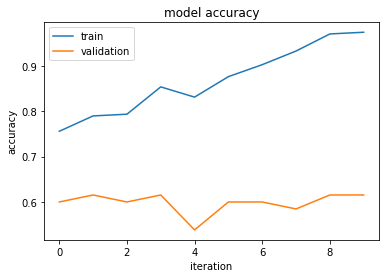

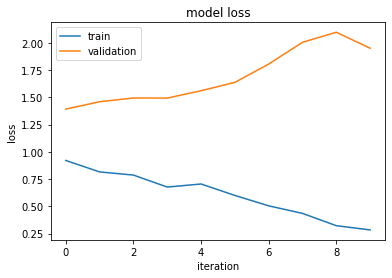

In [55]:
plotAccLoss(ftHistoriesE15)

## Increase dropout layer's rate from 0.3 to 0.5

c:\Users\User\Documents\UKM\Project\Models\EfficientNet\effNetVenv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 7)                 8967      
                                                                 
Total params: 4,058,538
Trainable params: 8,967
Non-trainable params: 4,049,571
_______________________________________________

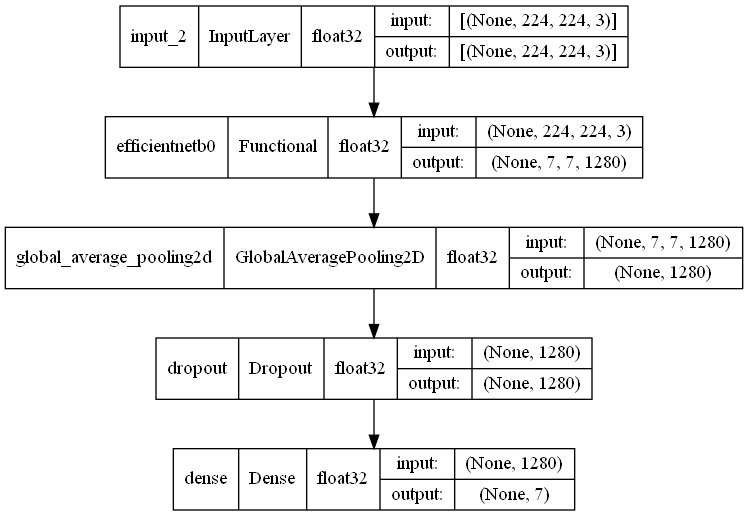

In [8]:
# ADD NEW TRAINABLE LAYERS ON TOP TO BUILD THE FINAL MODEL
from tensorflow.keras.layers.experimental.preprocessing import RandomContrast, RandomFlip
from tensorflow.keras.models import Model
from tensorflow.keras import Input, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

BASE_MODEL_DROPOUT50_PATH = './trainingWeights/baseModel-dropout50reg.h5'
inputs = Input(shape=(224,224,3))
#data_augmentation = Sequential([RandomFlip('horizontal'), RandomContrast(0.2)])
#x = preprocess_input(inputs)
x = effB0_model(inputs, training=False) #run in inference mode
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(7,activation='softmax', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))(x) #7 output classes
model6 = Model(inputs, outputs)
model6.save(BASE_MODEL_DROPOUT50_PATH)
model6.summary()
tf.keras.utils.plot_model(
    model6,
    to_file='./savedModel/EffB0-baseModel-dropout50Reg.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
)


In [10]:
from losocv import LosoCv

FOLDER_NAME = '.\\trainingWeights\\'
loso = LosoCv()
subject='smic-s5'
testSet = loso.getTestDataSet(subject)
trainDataset,valDataset = loso.getTrainValDataSet(subject)

model6 = load_model(BASE_MODEL_DROPOUT50_PATH)
headHistD50 = []

for i in range(10): 
    name = '{}model-{}-iteration{}-headtraining-11dec-dropout50'.format(FOLDER_NAME,subject, i)
    history1 = trainHead(model6,trainDataset, valDataset, name, batch_size=BATCH_SIZE, epoch=20)
    headHistD50.append(history1)

Learn the head
Epoch 1/20
9/9 [==============================] - ETA: 0s - loss: 4.9611 - accuracy: 0.2256 
Epoch 00001: val_loss improved from inf to 4.57498, saving model to .\trainingWeights\model-smic-s5-iteration0-headtraining-11dec-dropout50.h5


c:\Users\User\Documents\UKM\Project\Models\EfficientNet\effNetVenv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


9/9 [==============================] - 94s 10s/step - loss: 4.9611 - accuracy: 0.2256 - val_loss: 4.5750 - val_accuracy: 0.2615
Epoch 2/20
9/9 [==============================] - ETA: 0s - loss: 4.3729 - accuracy: 0.2556 
Epoch 00002: val_loss improved from 4.57498 to 4.11699, saving model to .\trainingWeights\model-smic-s5-iteration0-headtraining-11dec-dropout50.h5
9/9 [==============================] - 92s 10s/step - loss: 4.3729 - accuracy: 0.2556 - val_loss: 4.1170 - val_accuracy: 0.3231
Epoch 3/20
9/9 [==============================] - ETA: 0s - loss: 3.9128 - accuracy: 0.3496 
Epoch 00003: val_loss improved from 4.11699 to 3.70348, saving model to .\trainingWeights\model-smic-s5-iteration0-headtraining-11dec-dropout50.h5
9/9 [==============================] - 93s 10s/step - loss: 3.9128 - accuracy: 0.3496 - val_loss: 3.7035 - val_accuracy: 0.3692
Epoch 4/20
9/9 [==============================] - ETA: 0s - loss: 3.4702 - accuracy: 0.3346 
Epoch 00004: val_loss improved from 3.70348

c:\Users\User\Documents\UKM\Project\Models\EfficientNet\effNetVenv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


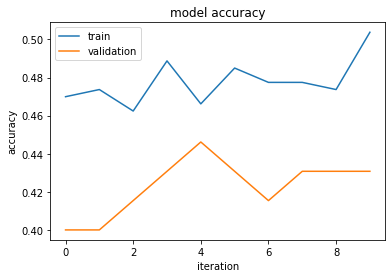

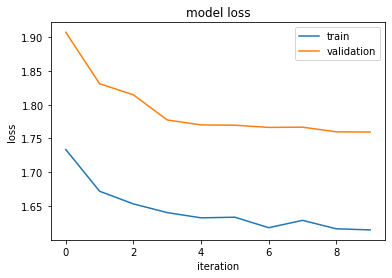

In [15]:
#visualize head training with dropout 50%
saveModelHistory('dec11','smic-s5-head-dropout50reg', headHistD50)
model6.save('./savedModel/bestHead-dropout50reg.h5')
plotAccLoss(headHistD50)

In [16]:
#fine tune the whole network
ftHistoriesD50 = []
for i in range (20):
    name = '{}model-{}-iteration{}-11dec-dropout50reg'.format(FOLDER_NAME,subject, i)
    fth = trainAll(model6,trainDataset, valDataset, name, epoch=20)
    ftHistoriesD50.append(fth)

Fine-tuning whole network
Epoch 1/20
9/9 [==============================] - ETA: 0s - loss: 1.6204 - accuracy: 0.4474
Epoch 00001: val_loss improved from inf to 1.72417, saving model to .\trainingWeights\model-smic-s5-iteration0-11dec-dropout50reg_finetune.h5


c:\Users\User\Documents\UKM\Project\Models\EfficientNet\effNetVenv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


9/9 [==============================] - 93s 10s/step - loss: 1.6204 - accuracy: 0.4474 - val_loss: 1.7242 - val_accuracy: 0.4154
Epoch 2/20
9/9 [==============================] - ETA: 0s - loss: 1.5437 - accuracy: 0.4850
Epoch 00002: val_loss improved from 1.72417 to 1.66370, saving model to .\trainingWeights\model-smic-s5-iteration0-11dec-dropout50reg_finetune.h5
9/9 [==============================] - 87s 10s/step - loss: 1.5437 - accuracy: 0.4850 - val_loss: 1.6637 - val_accuracy: 0.4308
Epoch 3/20
9/9 [==============================] - ETA: 0s - loss: 1.4645 - accuracy: 0.5188 
Epoch 00003: val_loss improved from 1.66370 to 1.64218, saving model to .\trainingWeights\model-smic-s5-iteration0-11dec-dropout50reg_finetune.h5
9/9 [==============================] - 93s 10s/step - loss: 1.4645 - accuracy: 0.5188 - val_loss: 1.6422 - val_accuracy: 0.5077
Epoch 4/20
9/9 [==============================] - ETA: 0s - loss: 1.4351 - accuracy: 0.5038 
Epoch 00004: val_loss improved from 1.64218 to

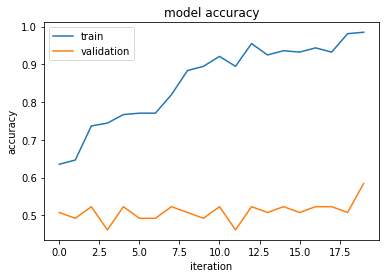

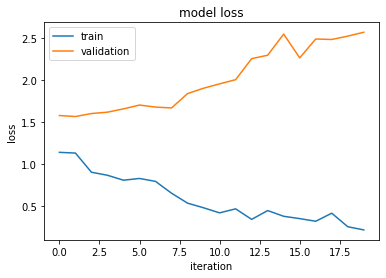

In [17]:
plotAccLoss(ftHistoriesD50)

## Data Augmentation

## Wire it all together 
1. Using LOSOCV, train a model for each leave-out training dataset for 10 iterations/runs with early stopping
2. The best model after the iterations will go through hyperparameters tuning
3. This model is used against test set

In [ ]:
bestModel = '{}model-{}-iteration-4_finetune.h5'.format(FOLDER_NAME,subject)
trainedModel = load_model(bestModel)
histFTP = finetune_hyperparam(trainedModel, trainDataset, valDataset, '{}model-{}-iteration-4'.format(FOLDER_NAME,subject))

Epoch 1/2
1/1 [==============================] - ETA: 0s - loss: 0.7087 - accuracy: 0.8125
Epoch 00001: val_accuracy improved from -inf to 0.35938, saving model to .\trainingWeights\model-samm-012-iteration-4_ft_sgd.h5


c:\Users\User\Documents\UKM\Project\Models\EfficientNet\effNetVenv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1/1 [==============================] - 28s 28s/step - loss: 0.7087 - accuracy: 0.8125 - val_loss: 1.5932 - val_accuracy: 0.3594
Epoch 2/2
1/1 [==============================] - ETA: 0s - loss: 1.2008 - accuracy: 0.6250
Epoch 00002: val_accuracy improved from 0.35938 to 0.37500, saving model to .\trainingWeights\model-samm-012-iteration-4_ft_sgd.h5
1/1 [==============================] - 15s 15s/step - loss: 1.2008 - accuracy: 0.6250 - val_loss: 1.5848 - val_accuracy: 0.3750


In [ ]:
import losocv

loso = losocv.LosoCv()
subjects = loso.getSubjects()
subjectsNum = len(subjects)
#LOSOCV is computationally expensive, will run 5 leave out subject at a time to prevent PC from crashing
loso_batch = 5   

#for subject in subjects:   #Leave one subject out as test set, and train the model
    